<a href="https://colab.research.google.com/github/Francesco0101/Computer-Vision-Project-on-Ground-To-Aerial-Matching/blob/main/Utils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#UTILS

##IMPORT

In [1]:
import os
from google.colab.patches import cv2_imshow #rimuovere se online
import cv2
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import csv
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, Mask2FormerForUniversalSegmentation
from transformers import Mask2FormerForUniversalSegmentation
import numpy as np
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


##NEEDED PATHS

In [3]:
#Francesco
bingmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/bingmap'
streetview_dir = '/content/drive/MyDrive/CV/CVUSA_subset/streetview'
cvusa_dir = '/content/drive/MyDrive/CV/CVUSA_subset'
csv_path = '/content/drive/MyDrive/CV/CVUSA_subset/file_paths.csv'
bingmap_depth_dir = '/content/drive/MyDrive/CV/CVUSA_subset/depth/bingmap'
streetview_depth_dir = '/content/drive/MyDrive/CV/CVUSA_subset/depth/streetview'
bingmap_segmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/segmap_new/bingmap'
streetview_segmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/segmap_new/streetview'
bingmap_sift_dir = '/content/drive/MyDrive/CV/CVUSA_subset/sift_img/bingmap'
streetview_sift_dir = '/content/drive/MyDrive/CV/CVUSA_subset/sift_img/streetview'
# #Simone Local
# bingmap_dir = 'CVUSA_subset/bingmap'
# streetview_dir = 'CVUSA_subset/streetview'
# bingmap_sift_dir = 'CVUSA_subset/sift/bingmap'
# streetview_sift_dir = 'CVUSA_subset/sift/streetview'
# cvusa_dir = 'CVUSA_subset'
# csv_path = 'CVUSA_subset/file_paths.csv'
# bingmap_depth_dir = 'CVUSA_subset/depth/bingmap'
# streetview_depth_dir = 'CVUSA_subset/depth/streetview'
# bingmap_segmap_dir = 'CVUSA_subset/segmap_new/bingmap'
# streetview_segmap_dir = 'CVUSA_subset/segmap_new/streetview'


(224, 1232, 3)


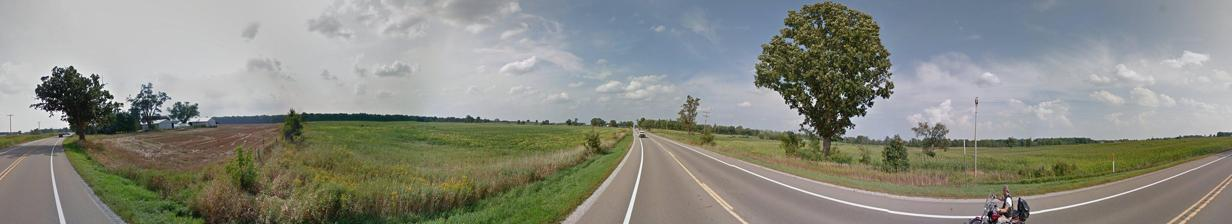

In [5]:
#visualizza una immagine da streetview_dir
image_path = os.path.join(streetview_dir, '0039398.jpg')
image = cv2.imread(image_path)
print(image.shape)
cv2_imshow(image)


##POLAR NEW

In [ ]:
import numpy as np
import os

#function from a japanese
def sample_within_bounds(signal, x, y, bounds):

    xmin, xmax, ymin, ymax = bounds

    idxs = (xmin <= x) & (x < xmax) & (ymin <= y) & (y < ymax)

    sample = np.zeros((x.shape[0], x.shape[1], signal.shape[-1]))
    sample[idxs, :] = signal[x[idxs], y[idxs], :]

    return sample


def sample_bilinear(signal, rx, ry):

    signal_dim_x = signal.shape[0]
    signal_dim_y = signal.shape[1]

    # obtain four sample coordinates
    ix0 = rx.astype(int)
    iy0 = ry.astype(int)
    ix1 = ix0 + 1
    iy1 = iy0 + 1

    bounds = (0, signal_dim_x, 0, signal_dim_y)

    # sample signal at each four positions
    signal_00 = sample_within_bounds(signal, ix0, iy0, bounds)
    signal_10 = sample_within_bounds(signal, ix1, iy0, bounds)
    signal_01 = sample_within_bounds(signal, ix0, iy1, bounds)
    signal_11 = sample_within_bounds(signal, ix1, iy1, bounds)

    na = np.newaxis
    # linear interpolation in x-direction
    fx1 = (ix1-rx)[...,na] * signal_00 + (rx-ix0)[...,na] * signal_10
    fx2 = (ix1-rx)[...,na] * signal_01 + (rx-ix0)[...,na] * signal_11

    # linear interpolation in y-direction
    return (iy1 - ry)[...,na] * fx1 + (ry - iy0)[...,na] * fx2


############################ Apply Polar Transform to Aerial Images in CVUSA Dataset #############################
S = 370  # Original size of the aerial image
height = 224  # Height of polar transformed aerial image
width = 1232   # Width of polar transformed aerial image

i = np.arange(0, height)
j = np.arange(0, width)
jj, ii = np.meshgrid(j, i)

y = S/2. - S/2./height*(height-1-ii)*np.sin(2*np.pi*jj/width)
x = S/2. + S/2./height*(height-1-ii)*np.cos(2*np.pi*jj/width)

input_dir = bingmap_dir
output_dir = 'CVUSA_subset/polar_new'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

images = os.listdir(input_dir)
for img in tqdm(images):

    img_path = os.path.join(input_dir, img)

    signal = cv2.imread(img_path)
        # Converti l'immagine da BGR a RGB per la visualizzazione
    signal_rgb = cv2.cvtColor(signal, cv2.COLOR_BGR2RGB)

    # Normalizza l'immagine tra 0 e 1
    normalized_signal = signal_rgb / 255.0

    image = sample_bilinear(normalized_signal, x, y)

    # Save the processed image to the output directory
    output_img_path = os.path.join(output_dir, img)
    # Convert image back to BGR for saving
    image_bgr = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_img_path, image_bgr)

POLAR NEW SEG

In [52]:
import numpy as np
import os

#function from a japanese

def sample_within_bounds(signal, x, y, bounds):

    xmin, xmax, ymin, ymax = bounds

    idxs = (xmin <= x) & (x < xmax) & (ymin <= y) & (y < ymax)

    sample = np.zeros((x.shape[0], x.shape[1], signal.shape[-1]))
    sample[idxs, :] = signal[x[idxs], y[idxs], :]

    return sample


def sample_bilinear(signal, rx, ry):

    signal_dim_x = signal.shape[0]
    signal_dim_y = signal.shape[1]

    # obtain four sample coordinates
    ix0 = rx.astype(int)
    iy0 = ry.astype(int)
    ix1 = ix0 + 1
    iy1 = iy0 + 1

    bounds = (0, signal_dim_x, 0, signal_dim_y)

    # sample signal at each four positions
    signal_00 = sample_within_bounds(signal, ix0, iy0, bounds)
    signal_10 = sample_within_bounds(signal, ix1, iy0, bounds)
    signal_01 = sample_within_bounds(signal, ix0, iy1, bounds)
    signal_11 = sample_within_bounds(signal, ix1, iy1, bounds)

    na = np.newaxis
    # linear interpolation in x-direction
    fx1 = (ix1-rx)[...,na] * signal_00 + (rx-ix0)[...,na] * signal_10
    fx2 = (ix1-rx)[...,na] * signal_01 + (rx-ix0)[...,na] * signal_11

    # linear interpolation in y-direction
    return (iy1 - ry)[...,na] * fx1 + (ry - iy0)[...,na] * fx2


############################ Apply Polar Transform to Aerial Images in CVUSA Dataset #############################
S = 370  # Original size of the aerial image
height = 224  # Height of polar transformed aerial image
width = 1232   # Width of polar transformed aerial image

i = np.arange(0, height)
j = np.arange(0, width)
jj, ii = np.meshgrid(j, i)

y = S/2. - S/2./height*(height-1-ii)*np.sin(2*np.pi*jj/width)
x = S/2. + S/2./height*(height-1-ii)*np.cos(2*np.pi*jj/width)

input_dir = bingmap_segmap_dir
output_dir = 'drive/MyDrive/CV/CVUSA_subset/polar_new_seg'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

images = os.listdir(input_dir)
for img in tqdm(images):

    img_path = os.path.join(input_dir, img)

    signal = cv2.imread(img_path)

    image = sample_bilinear(signal, x, y)

    output_img_path = os.path.join(output_dir, img)

    cv2.imwrite(output_img_path, image)

100%|██████████| 8862/8862 [28:27<00:00,  5.19it/s]


In [13]:
#numero di sample in polar_new

print(len(os.listdir('drive/MyDrive/CV/CVUSA_subset/polar_new')))


8862


##SIFT

In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from google.colab.patches import cv2_imshow
# Definisci le liste per salvare i descrittori
Aerial_sift = []
Ground_sift = []

def extract_sift_keypoints(image_path, output_path):
    # Leggi l'immagine in scala di grigi
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Crea un oggetto SIFT
    sift = cv2.SIFT_create()

    # Trova keypoints e descrittori
    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:
        # Disegna i keypoints sull'immagine originale
        image_with_keypoints = cv2.drawKeypoints(
            image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )

        # Visualizza l'immagine con i keypoints
        # Salva l'immagine con i keypoints disegnati
        cv2.imwrite(output_path, image_with_keypoints)
    else:
        print("No descriptors found.")
        image_try = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.imwrite(output_path, image_try)



# Lista dei file
bingmap_files = os.listdir(bingmap_dir)
streetview_files = os.listdir(streetview_dir)

# Esempio di utilizzo per estrarre e salvare le immagini con SIFT visualizzato
for file in tqdm(bingmap_files):
    if file.endswith(".png"):
        image_path = os.path.join(bingmap_dir, file)
        output_path = os.path.join("CVUSA_subset/sift_img/bingmap/", f"sift_visualized_{file}")
        extract_sift_keypoints(image_path, output_path)

for file in tqdm(streetview_files):
    if file.endswith(".jpg"):
        image_path = os.path.join(streetview_dir, file)
        output_path = os.path.join("CVUSA_subset/sift_img/streetview/", f"sift_visualized_{file}")
        extract_sift_keypoints(image_path, output_path)


  1%|          | 59/8862 [00:11<28:55,  5.07it/s]


KeyboardInterrupt: 

##  Depth and Segmap


In [14]:
depth_image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
# Load segmentation model
seg_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-ade-semantic")
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-ade-semantic")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/82.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

In [15]:

# Create output directories
depth_aerial_dir = 'CVUSA_subset/depth_aerial'
seg_aerial_dir = 'CVUSA_subset/seg_aerial'
depth_ground_dir = 'CVUSA_subset/depth_ground'
seg_ground_dir = 'CVUSA_subset/seg_ground'

os.makedirs(depth_aerial_dir, exist_ok=True)
os.makedirs(seg_aerial_dir, exist_ok=True)
os.makedirs(depth_ground_dir, exist_ok=True)
os.makedirs(seg_ground_dir, exist_ok=True)

# List files in each directory
polar_dir = 'drive/MyDrive/CV/CVUSA_subset/polar_new'
bingmap_files = [os.path.join(bingmap_dir, f) for f in os.listdir(bingmap_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
streetview_files = [os.path.join(streetview_dir, f) for f in os.listdir(streetview_dir) if f.endswith(('png', 'jpg', 'jpeg'))]



def process_image(image_path, depth_output_dir, seg_output_dir):
    image = Image.open(image_path)

    # Process depth estimation
    depth_inputs = depth_image_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        depth_outputs = depth_model(**depth_inputs)
        predicted_depth = depth_outputs.predicted_depth
        depth_prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()
    depth_output_path = os.path.join(depth_output_dir, os.path.basename(image_path))
    depth_image = Image.fromarray((depth_prediction * 255 / depth_prediction.max()).astype('uint8'))
    depth_image.save(depth_output_path)

    # Process segmentation
    seg_inputs = seg_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        seg_outputs = seg_model(**seg_inputs)
    predicted_segmentation = seg_processor.post_process_semantic_segmentation(seg_outputs, target_sizes=[image.size[::-1]])[0]
    seg_output_path = os.path.join(seg_output_dir, os.path.basename(image_path))
    seg_image = Image.fromarray(predicted_segmentation.numpy().astype('uint8'))
    seg_image.save(seg_output_path)

In [16]:
for image_path in tqdm(bingmap_files):
    process_image(image_path, depth_aerial_dir, seg_aerial_dir)

  0%|          | 4/8862 [00:38<23:51:58,  9.70s/it]


KeyboardInterrupt: 

In [ ]:
for image_path in tqdm(streetview_files):
    process_image(image_path, depth_ground_dir, seg_ground_dir)

  0%|          | 3/8862 [00:26<21:49:11,  8.87s/it]


KeyboardInterrupt: 

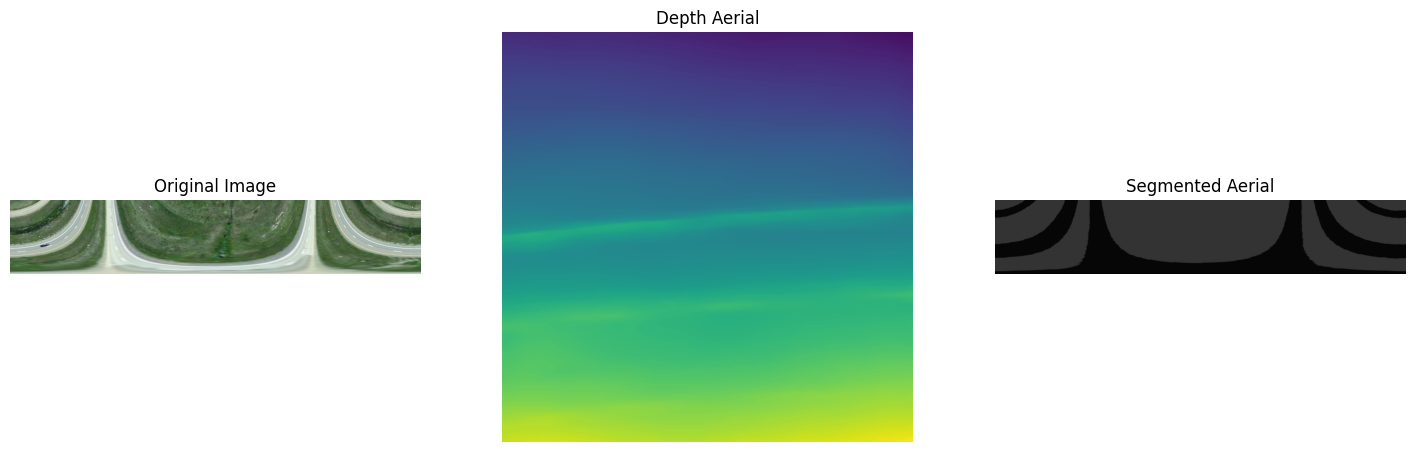

In [42]:
# Load images
image = Image.open("drive/MyDrive/CV/CVUSA_subset/depth/bingmap/input0039214.png")
image_seg = Image.open("drive/MyDrive/CV/CVUSA_subset/polar_new_seg/input0039214.png")
image_og = Image.open("drive/MyDrive/CV/CVUSA_subset/polar_new/input0039214.png")

# Create a figure with a specified size
plt.figure(figsize=(18, 6))

# Display the original image in the first subplot
plt.subplot(1, 3, 1)
plt.imshow(image_og,  cmap='jet')
plt.title('Original Image')
plt.axis('off')

# Display the depth aerial image in the second subplot
plt.subplot(1, 3, 2)
plt.imshow(image)
plt.title('Depth Aerial')
plt.axis('off')

# Display the segmented aerial image in the third subplot
plt.subplot(1, 3, 3)
plt.imshow(image_seg)
plt.title('Segmented Aerial')
plt.axis('off')

# Show the plot
plt.show()


##CSV creation

In [ ]:
import os
import re
import csv

# Function to extract numeric identifier from filenames
def extract_identifier(filename):
    match = re.search(r'\d+', filename)
    return match.group() if match else None

# Read files from directories
bingmap_files = sorted(os.listdir(bingmap_dir))
streetview_files = sorted(os.listdir(streetview_dir))
bingmap_sift_files = sorted(os.listdir(bingmap_sift_dir))
streetview_sift_files = sorted(os.listdir(streetview_sift_dir))
streetview_depth_files = sorted(os.listdir(streetview_depth_dir))
bingmap_depth_files = sorted(os.listdir(bingmap_depth_dir))
streetview_segmap_files = sorted(os.listdir(streetview_segmap_dir))
bingmap_segmap_files = sorted(os.listdir(bingmap_segmap_dir))

# Print the number of files found in each directory
print(len(bingmap_files))
print(len(streetview_files))
print(len(bingmap_sift_files))
print(len(streetview_sift_files))
print(len(streetview_depth_files))
print(len(bingmap_depth_files))
print(len(streetview_segmap_files))
print(len(bingmap_segmap_files))

# Create dictionaries to map identifiers to filenames
bingmap_dict = {extract_identifier(f): f for f in bingmap_files}
streetview_dict = {extract_identifier(f): f for f in streetview_files}
bingmap_sift_dict = {extract_identifier(f): f for f in bingmap_sift_files}
streetview_sift_dict = {extract_identifier(f): f for f in streetview_sift_files}
streetview_depth_dict = {extract_identifier(f): f for f in streetview_depth_files}
bingmap_depth_dict = {extract_identifier(f): f for f in bingmap_depth_files}
streetview_segmap_dict = {extract_identifier(f): f for f in streetview_segmap_files}
bingmap_segmap_dict = {extract_identifier(f): f for f in bingmap_segmap_files}

# Find all identifiers
all_identifiers = set(bingmap_dict.keys()).union(
    streetview_dict.keys(),
    bingmap_sift_dict.keys(),
    streetview_sift_dict.keys(),
    streetview_depth_dict.keys(),
    bingmap_depth_dict.keys(),
    streetview_segmap_dict.keys(),
    bingmap_segmap_dict.keys()
)

# Write file paths to CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    for identifier in all_identifiers:
        bingmap_file = bingmap_dict.get(identifier, "None")
        streetview_file = streetview_dict.get(identifier, "None")
        bingmap_sift_file = bingmap_sift_dict.get(identifier, "None")
        streetview_sift_file = streetview_sift_dict.get(identifier, "None")
        streetview_depth_file = streetview_depth_dict.get(identifier, "None")
        bingmap_depth_file = bingmap_depth_dict.get(identifier, "None")
        streetview_segmap_file = streetview_segmap_dict.get(identifier, "None")
        bingmap_segmap_file = bingmap_segmap_dict.get(identifier, "None")

        bingmap_path = f"{bingmap_dir}/{bingmap_file}" if bingmap_file != "None" else "None"
        streetview_path = f"{streetview_dir}/{streetview_file}" if streetview_file != "None" else "None"
        bingmap_sift_path = f"{bingmap_sift_dir}/{bingmap_sift_file}" if bingmap_sift_file != "None" else "None"
        streetview_sift_path = f"{streetview_sift_dir}/{streetview_sift_file}" if streetview_sift_file != "None" else "None"
        bingmap_depth_path = f"{bingmap_depth_dir}/{bingmap_depth_file}" if bingmap_depth_file != "None" else "None"
        streetview_depth_path = f"{streetview_depth_dir}/{streetview_depth_file}" if streetview_depth_file != "None" else "None"
        bingmap_segmap_path = f"{bingmap_segmap_dir}/{bingmap_segmap_file}" if bingmap_segmap_file != "None" else "None"
        streetview_segmap_path = f"{streetview_segmap_dir}/{streetview_segmap_file}" if streetview_segmap_file != "None" else "None"

        writer.writerow([bingmap_path, streetview_path, bingmap_sift_path, streetview_sift_path, bingmap_depth_path, streetview_depth_path, bingmap_segmap_path, streetview_segmap_path])

print(f"CSV creato con successo in {csv_path}")



8862
8862
8862
8862
8862
8862
8862
8862
CSV creato con successo in CVUSA_subset/file_paths.csv
